In [2]:
import pandas as pd
import numpy as np
import spacy
import time

import nltk
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from gensim.models import Word2Vec, FastText, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from sklearn.metrics import f1_score
from collections import Counter, defaultdict
from html import unescape

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder, normalize

from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

np.random.seed(0)

import helper as h
import helper_word2vec as h2
%matplotlib inline

In [26]:
df = pd.read_csv('recovery_dataset.csv')

df['doc_id'] = df.index
df = df[['doc_id', 'target', 'text']]

df.sample(10)

,doc_id,target,text
1167,1167,fake,Dr. Andrew Kaufman may be the most censored do...
1174,1174,true,C. Jarrett Dieterle and Teri Quimby\n\nOpinion...
21,21,fake,Becoming the world's most advanced and largest...
798,798,true,The FBI alongside the Department of Homeland S...
267,267,true,Three immigrants and a correctional officer at...
780,780,true,14 Hours And A Costco Card: How A Grocer In Al...
774,774,true,WASHINGTON — The FBI and the Department of Hom...
950,950,true,A top World Health Organization official warne...
1400,1400,fake,Amid the COVID-19 pandemic and ensuing travel ...
1374,1374,true,The debate over the use of anti-malaria drug h...


In [27]:
# Skrypt do przeprowadzenia automatycznego preprocessingu korpusu:
# usunięcie nadmiarowych odstępów
# usunięcie adresów URL
# usunięcie liczb
# usunięcie hasztagów
# usunięcie znaków specjalnych
# usunięcie pojedynczych znaków
# standaryzacja poprzez usunięcie liczb ze słów "covid-19" oraz "sars-cov-2"


import re
from html import unescape

def re_urls(text, replace_for="URL"):
    return re.sub(r'https?://\S+', replace_for, text) 

def re_digits(text, replace_for='DIGIT'): 
    result = re.sub(r'\d+', replace_for, text) 
    return result

def re_topic(text, replace_for=r'\1'):
    return re.sub(r'#(\S+)', replace_for, text)

def re_multi_spaces_into_one(text, replace_for=' '):
    return re.sub(r'\s+', replace_for, text)

def re_alias(text, replace_for=r'\1'):
    return re.sub(r'@(\S+)', replace_for, text)
    
def make_unescape(text):
    return unescape(text)

def re_clean_dirty_data(doc):
    doc = doc.replace("<br />", "")
    doc = doc.replace("DIGIT%", "DIGIT")
    doc = doc.replace("DIGIT.DIGIT", "DIGIT")  
    doc = doc.replace("DIGIT,DIGIT", "DIGIT")
    doc = doc.replace("$DIGIT", "DIGIT")
    doc = doc.replace("DIGIT-DIGIT", "DIGIT")
    return doc

def re_covid_replace(doc):
    doc = doc.replace("covid-19", "covid")
    doc = doc.replace("sars-cov-2", "coronavirus")
    return doc

def preprocessing(doc):
    doc = make_unescape(doc)
    doc = re_multi_spaces_into_one(doc)
    doc = re_urls(doc)
    doc = re_topic(doc)
    doc = re_alias(doc)
    doc = re_covid_replace(doc)
    doc = re_digits(doc)
    doc = re_clean_dirty_data(doc)
    return doc

In [28]:
# Preprocessing za pomocą pakietu Gensim
df['text_lower'] = df['text'].str.lower()

#Usunięcie podstawowych stop-words
stop_words = ['the', 'an', 'a']
df['text_nostop'] = df['text_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Preprocessing ze skryptu
df['text_clean'] = df['text_nostop'].map(preprocessing)

# Tokenizacja Gensim
df['tokens'] = df['text_clean'].map(simple_preprocess)

df.sample(5)

,doc_id,target,text,text_lower,text_nostop,text_clean,tokens
789,789,true,"CBS MoneyWatch spoke with Dr. Tom Frieden, who...","cbs moneywatch spoke with dr. tom frieden, who...","cbs moneywatch spoke with dr. tom frieden, who...","cbs moneywatch spoke with dr. tom frieden, who...","[cbs, moneywatch, spoke, with, dr, tom, friede..."
1193,1193,true,"A week ago Friday, 10 Delta Airlines jetliners...","a week ago friday, 10 delta airlines jetliners...","week ago friday, 10 delta airlines jetliners f...","week ago friday, DIGIT delta airlines jetliner...","[week, ago, friday, digit, delta, airlines, je..."
1052,1052,true,Millions of sports fans will be watching their...,millions of sports fans will be watching their...,millions of sports fans will be watching their...,millions of sports fans will be watching their...,"[millions, of, sports, fans, will, be, watchin..."
1217,1217,fake,This article best articulates the fight agains...,this article best articulates the fight agains...,this article best articulates fight against co...,this article best articulates fight against co...,"[this, article, best, articulates, fight, agai..."
909,909,true,The coronavirus pandemic has claimed more than...,the coronavirus pandemic has claimed more than...,"coronavirus pandemic has claimed more than 85,...",coronavirus pandemic has claimed more than DIG...,"[coronavirus, pandemic, has, claimed, more, th..."


In [151]:
%%time
# Tokenizacja z lemmatyzacją Spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def get_lemma(doc):
    return [token.lemma_ for token in doc if not token.is_punct and token.lemma_ != "-PRON-"]

df['tokens_lemma'] = df['text_clean'].map(nlp).map(get_lemma)

Wall time: 3min 27s


### Przygotowane tokeny trafią do trzech wektorowych modeli reprezentacji tekstu:
- Word2Vec
- Doc2Vec
- FastText

model=dummy, f1: mean=0.7775, std=0.03, calc_time=0.01 sec.
model=decision tree, f1: mean=0.8795, std=0.01, calc_time=0.23 sec.
model=random forest, f1: mean=0.898, std=0.01, calc_time=0.97 sec.
model=extra-trees, f1: mean=0.8843, std=0.0, calc_time=0.3 sec.
model=xgboost, f1: mean=0.9214, std=0.01, calc_time=1.38 sec.
model=lightgbm, f1: mean=0.916, std=0.0, calc_time=0.45 sec.
model=catboost, f1: mean=0.9122, std=0.01, calc_time=1.86 sec.


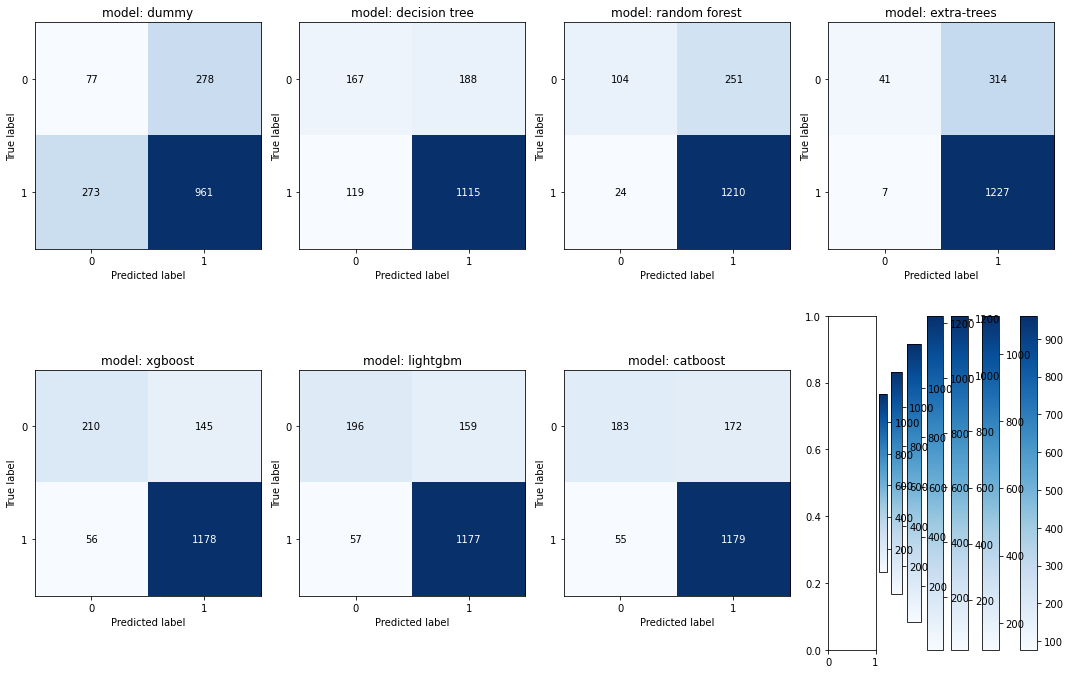

[('dummy', 0.7775, 0.03, 0.01),
 ('decision tree', 0.8795, 0.01, 0.23),
 ('random forest', 0.898, 0.01, 0.97),
 ('extra-trees', 0.8843, 0.0, 0.3),
 ('xgboost', 0.9214, 0.01, 1.38),
 ('lightgbm', 0.916, 0.0, 0.45),
 ('catboost', 0.9122, 0.01, 1.86)]

In [7]:
# Word2Vec

tokens = df['tokens']

model = Word2Vec(tokens, vector_size=100, sg=1, hs=1, window=3)

X = h2.get_doc2vec_X(model, tokens)
le = LabelEncoder()
y = le.fit_transform(df["target"])

kwargs = {'scoring': 'f1', 
          'cv': 5, 
          'plot_result': False,
          'show_confusion_matrix': True
         }

h2.run_models(X, y, **kwargs)

model=dummy, f1: mean=0.7843, std=0.01, calc_time=0.02 sec.
model=decision tree, f1: mean=0.8759, std=0.02, calc_time=0.47 sec.
model=random forest, f1: mean=0.8959, std=0.01, calc_time=1.24 sec.
model=extra-trees, f1: mean=0.8845, std=0.01, calc_time=0.35 sec.
model=xgboost, f1: mean=0.9225, std=0.01, calc_time=2.18 sec.
model=lightgbm, f1: mean=0.913, std=0.01, calc_time=0.82 sec.
model=catboost, f1: mean=0.9122, std=0.01, calc_time=3.35 sec.


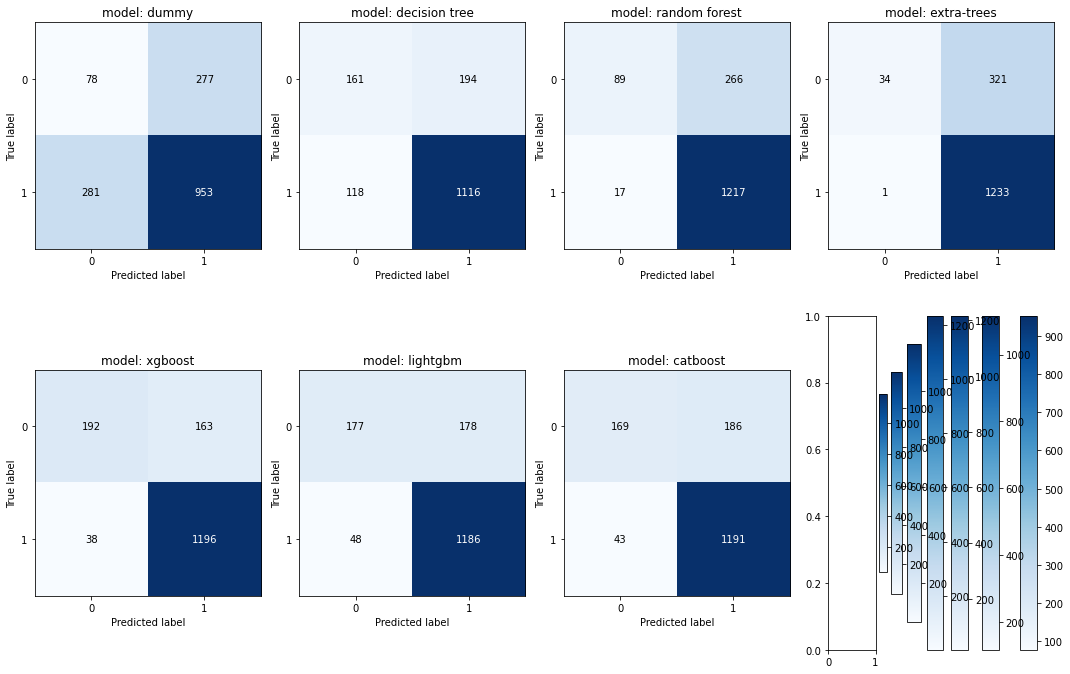

[('dummy', 0.7843, 0.01, 0.02),
 ('decision tree', 0.8759, 0.02, 0.47),
 ('random forest', 0.8959, 0.01, 1.24),
 ('extra-trees', 0.8845, 0.01, 0.35),
 ('xgboost', 0.9225, 0.01, 2.18),
 ('lightgbm', 0.913, 0.01, 0.82),
 ('catboost', 0.9122, 0.01, 3.35)]

In [30]:
# Doc2Vec

def get_tagged_docs(x):
    words = x['tokens']
    tags = [x['doc_id']]
    return TaggedDocument(words=words, tags=tags)

tagged_docs = df.apply(get_tagged_docs, axis=1)

model = Doc2Vec(tagged_docs, vector_size=200, dbow_words=2, hs=2, window=5, seed=1)

X = h2.get_doc2vec_X(model, tokens)
le = LabelEncoder()
y = le.fit_transform(df["target"])

kwargs = {'scoring': 'f1', 
          'cv': 5, 
          'plot_result': False
         }

h2.run_models(X, y, **kwargs)

## Hiperparametryzacja - poszukiwanie optymalnej kombinacji parametrów dla danego modelu

### Word2Vec
Pętla testująca 64 modeli prezentacji tekstu wsadowego z różnymi kombinacjami hiperparametrów. Do przeprowadzenia klasyfikacji wybrałem 3 najskuteczniejsze algorytmy wyłonione z wcześniejszych prób. Daje to łącznie 192 końcowych modeli, których wyniki skuteczności zapisywane są do tabeli za pomocą miary F1.

In [137]:
%%time

# Word2Vec - pętla testująca 64 modeli z różnymi kombinacjami hiperparametrów
# Do przeprowadzenia klasyfikacji wybrałem 3 najskuteczniejsze algorytmy wyłonione z wcześniejszych prób
# Daje to łącznie 192 końcowych modeli, których wyniki skuteczności zapisywane są do tabeli za pomocą miary F1

sizes=[80, 100, 130, 180]
windows=[8, 12, 15, 18]
sgs=[0, 1]
hss=[0, 1]

selected_models = ['xgboost', 'catboost', 'lightgbm']
tokens = df['tokens']

kwargs = {'scoring': 'f1', 
          'cv': 5, 
          'plot_result': False,
          'show_confusion_matrix': False
         }

df_results_w2v = pd.DataFrame(columns=['model','f1','f1 std','calc_time','size','window','sg', 'hs'])

i=0
for size in sizes:    
    for window in windows:           
        for sg in sgs:   
            for hs in hss:
                
                i=i+1
                print(f'------{i} from 64------')
                print("Loop for size: {}".format(str(size)))
                print("Loop for window: {}".format(str(window)))
                print("Loop for sg: {}".format(str(sg)))
                print("Loop for hs: {}".format(str(hs)))
                print("-------start-------")                

                model = Word2Vec(tokens, vector_size=size, window=window, sg=sg, hs=hs) 

                X = h2.get_doc2vec_X(model, tokens)
                le = LabelEncoder()
                y = le.fit_transform(df["target"])

                calc_tmp = h2.run_models(X, y, selected_models_list=selected_models, **kwargs)

                df_results_w2v.loc[len(df_results_w2v)] = calc_tmp[0]+(size,window,sg,hs)
                df_results_w2v.loc[len(df_results_w2v)] = calc_tmp[1]+(size,window,sg,hs)
                df_results_w2v.loc[len(df_results_w2v)] = calc_tmp[2]+(size,window,sg,hs)
                    
                print("-------end--------")
                print(" ")

------1 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.8943, std=0.01, calc_time=1.17 sec.
model=lightgbm, f1: mean=0.8962, std=0.01, calc_time=0.33 sec.
model=catboost, f1: mean=0.8905, std=0.01, calc_time=1.56 sec.
-------end--------
 
------2 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9108, std=0.01, calc_time=1.14 sec.
model=lightgbm, f1: mean=0.9021, std=0.01, calc_time=0.34 sec.
model=catboost, f1: mean=0.8988, std=0.01, calc_time=1.65 sec.
-------end--------
 
------3 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9157, std=0.01, calc_time=1.14 sec.
model=lightgbm, f1: mean=0.913, std=0.01, calc_time=0.35 sec.
model=catboost, f1: mean=0.9057, std=0.01, calc_time=1.65 sec.
-------end--------
 
------4 from 64------
Loop for size: 80
Loop fo

model=catboost, f1: mean=0.9096, std=0.01, calc_time=1.98 sec.
-------end--------
 
------27 from 64------
Loop for size: 100
Loop for window: 15
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9261, std=0.01, calc_time=1.36 sec.
model=lightgbm, f1: mean=0.9228, std=0.01, calc_time=0.43 sec.
model=catboost, f1: mean=0.9188, std=0.01, calc_time=1.88 sec.
-------end--------
 
------28 from 64------
Loop for size: 100
Loop for window: 15
Loop for sg: 1
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9307, std=0.01, calc_time=1.39 sec.
model=lightgbm, f1: mean=0.9326, std=0.0, calc_time=0.45 sec.
model=catboost, f1: mean=0.9267, std=0.01, calc_time=2.31 sec.
-------end--------
 
------29 from 64------
Loop for size: 100
Loop for window: 18
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9054, std=0.01, calc_time=1.5 sec.
model=lightgbm, f1: mean=0.9039, std=0.02, calc_time=0.4 sec.
model=catboost, f1: mean=0.8996, std=0.0

model=lightgbm, f1: mean=0.927, std=0.01, calc_time=0.78 sec.
model=catboost, f1: mean=0.9252, std=0.01, calc_time=3.12 sec.
-------end--------
 
------53 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9111, std=0.01, calc_time=2.26 sec.
model=lightgbm, f1: mean=0.9092, std=0.01, calc_time=0.77 sec.
model=catboost, f1: mean=0.9027, std=0.01, calc_time=3.1 sec.
-------end--------
 
------54 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9162, std=0.01, calc_time=2.17 sec.
model=lightgbm, f1: mean=0.9109, std=0.01, calc_time=0.7 sec.
model=catboost, f1: mean=0.906, std=0.01, calc_time=2.95 sec.
-------end--------
 
------55 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9232, std=0.01, calc_time=2.11 sec.
model=lightgbm, f1: mean=0.9213, std=0.0,

### 10 najlepszych wyników Word2Vec

In [140]:
# wyświetlenie 10 najlepszych wyników
df_results_w2v.sort_values(by=['f1'], ascending=False)[0:10]

,model,f1,f1 std,calc_time,size,window,sg,hs
93,xgboost,0.9356,0.01,1.34,100,18,1,1
33,xgboost,0.9337,0.01,1.13,80,15,1,1
189,xgboost,0.9328,0.00,2.25,180,18,1,1
82,lightgbm,0.9326,0.00,0.45,100,15,1,1
31,lightgbm,0.9315,0.01,0.36,80,15,1,0
153,xgboost,0.9313,0.01,2.04,180,8,1,1
191,catboost,0.9312,0.00,3.31,180,18,1,1
35,catboost,0.9311,0.00,1.65,80,15,1,1
30,xgboost,0.9308,0.01,1.13,80,15,1,0
190,lightgbm,0.9307,0.01,0.87,180,18,1,1


### Doc2Vec
Pętla testująca 64 modeli prezentacji tekstu wsadowego z różnymi kombinacjami hiperparametrów. Do przeprowadzenia klasyfikacji wybrałem 3 najskuteczniejsze algorytmy wyłonione z wcześniejszych prób. Daje to łącznie 192 końcowych modeli, których wyniki skuteczności zapisywane są do tabeli za pomocą miary F1.

In [150]:
%%time

sizes=[80, 100, 150, 200]
windows=[4, 8, 12, 15]
sgs=[0, 1]
hss=[0, 1]

selected_models = ['xgboost', 'catboost', 'lightgbm']
tokens = df['tokens']

kwargs = {'scoring': 'f1', 
          'cv': 5, 
          'plot_result': False,
          'show_confusion_matrix': False
         }

def get_tagged_docs(x):
    words = x['tokens']
    tags = [x['doc_id']]
    return TaggedDocument(words=words, tags=tags)

tagged_docs = df.apply(get_tagged_docs, axis=1)

df_results_d2v = pd.DataFrame(columns=['model','f1','f1 std','calc_time','size','window','sg', 'hs'])

i=0
for size in sizes:    
    for window in windows:           
        for sg in sgs:   
            for hs in hss:
                
                i=i+1
                print(f'------{i} from 64------')
                print("Loop for size: {}".format(str(size)))
                print("Loop for window: {}".format(str(window)))
                print("Loop for dbow_words: {}".format(str(sg)))
                print("Loop for hs: {}".format(str(hs)))
                print("-------start-------")                

                model = Doc2Vec(tagged_docs, vector_size=size, window=window, dbow_words=sg, hs=hs) 

                X = h2.get_doc2vec_X(model, tokens)
                le = LabelEncoder()
                y = le.fit_transform(df["target"])

                calc_tmp = h2.run_models(X, y, selected_models_list=selected_models, **kwargs)

                df_results_d2v.loc[len(df_results_d2v)] = calc_tmp[0]+(size,window,sg,hs)
                df_results_d2v.loc[len(df_results_d2v)] = calc_tmp[1]+(size,window,sg,hs)
                df_results_d2v.loc[len(df_results_d2v)] = calc_tmp[2]+(size,window,sg,hs)
                    
                print("-------end--------")
                print(" ")

------1 from 64------
Loop for size: 80
Loop for window: 4
Loop for dbow_words: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9045, std=0.01, calc_time=1.29 sec.
model=lightgbm, f1: mean=0.9004, std=0.01, calc_time=0.43 sec.
model=catboost, f1: mean=0.9008, std=0.01, calc_time=1.84 sec.
-------end--------
 
------2 from 64------
Loop for size: 80
Loop for window: 4
Loop for dbow_words: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.911, std=0.01, calc_time=1.15 sec.
model=lightgbm, f1: mean=0.9039, std=0.01, calc_time=0.38 sec.
model=catboost, f1: mean=0.9057, std=0.01, calc_time=1.7 sec.
-------end--------
 
------3 from 64------
Loop for size: 80
Loop for window: 4
Loop for dbow_words: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9105, std=0.01, calc_time=1.17 sec.
model=lightgbm, f1: mean=0.9026, std=0.01, calc_time=0.36 sec.
model=catboost, f1: mean=0.9024, std=0.01, calc_time=1.66 sec.
-------end--------
 
------4 from 64------
Lo

model=xgboost, f1: mean=0.9227, std=0.01, calc_time=1.52 sec.
model=lightgbm, f1: mean=0.9206, std=0.01, calc_time=0.52 sec.
model=catboost, f1: mean=0.9155, std=0.01, calc_time=2.09 sec.
-------end--------
 
------27 from 64------
Loop for size: 100
Loop for window: 12
Loop for dbow_words: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9142, std=0.01, calc_time=1.51 sec.
model=lightgbm, f1: mean=0.9166, std=0.01, calc_time=0.63 sec.
model=catboost, f1: mean=0.9123, std=0.01, calc_time=2.19 sec.
-------end--------
 
------28 from 64------
Loop for size: 100
Loop for window: 12
Loop for dbow_words: 1
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.917, std=0.01, calc_time=1.45 sec.
model=lightgbm, f1: mean=0.9134, std=0.01, calc_time=0.48 sec.
model=catboost, f1: mean=0.9145, std=0.01, calc_time=2.09 sec.
-------end--------
 
------29 from 64------
Loop for size: 100
Loop for window: 15
Loop for dbow_words: 0
Loop for hs: 0
-------start-------
model=xgboost,

model=lightgbm, f1: mean=0.9113, std=0.01, calc_time=0.76 sec.
model=catboost, f1: mean=0.8979, std=0.01, calc_time=3.28 sec.
-------end--------
 
------52 from 64------
Loop for size: 200
Loop for window: 4
Loop for dbow_words: 1
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9113, std=0.01, calc_time=2.67 sec.
model=lightgbm, f1: mean=0.9072, std=0.01, calc_time=1.14 sec.
model=catboost, f1: mean=0.9103, std=0.01, calc_time=3.47 sec.
-------end--------
 
------53 from 64------
Loop for size: 200
Loop for window: 8
Loop for dbow_words: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9148, std=0.01, calc_time=2.69 sec.
model=lightgbm, f1: mean=0.9106, std=0.01, calc_time=0.82 sec.
model=catboost, f1: mean=0.9118, std=0.01, calc_time=3.27 sec.
-------end--------
 
------54 from 64------
Loop for size: 200
Loop for window: 8
Loop for dbow_words: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9114, std=0.0, calc_time=2.31 sec.
model=lightgbm, f

### 10 najlepszych wyników Doc2Vec

In [8]:
# wyświetlenie 10 najlepszych wyników
df_results_d2v.sort_values(by=['f1'], ascending=False)[0:10]

NameError: name 'df_results_d2v' is not defined

### FastText 
Pętla testująca 64 modeli prezentacji tekstu wsadowego z różnymi kombinacjami hiperparametrów. Do przeprowadzenia klasyfikacji wybrałem 3 najskuteczniejsze algorytmy wyłonione z wcześniejszych prób. Daje to łącznie 192 końcowych modeli, których wyniki skuteczności zapisywane są do tabeli za pomocą miary F1.

In [19]:
%%time

sizes=[80, 100, 130, 180]
windows=[8, 12, 15, 18]
sgs=[0, 1]
hss=[0, 1]


selected_models = ['xgboost', 'catboost', 'lightgbm']
tokens = df['tokens']

kwargs = {'scoring': 'f1', 
          'cv': 5, 
          'plot_result': False,
          'show_confusion_matrix': False
         }

df_results_fasttext = pd.DataFrame(columns=['model','f1','f1 std','calc_time','size','window','sg', 'hs'])

i=0
for size in sizes:    
    for window in windows:           
        for sg in sgs:
            for hs in hss:
                
                i=i+1
                print(f'------{i} from 64------')
                print("Loop for size: {}".format(str(size)))
                print("Loop for window: {}".format(str(window)))
                print("Loop for sg: {}".format(str(sg)))
                print("Loop for hs: {}".format(str(hs)))
                print("-------start-------")                

                model = FastText(tokens, vector_size=size, window=window, sg=sg, hs=hs) 

                X = h2.get_doc2vec_X(model, tokens)
                le = LabelEncoder()
                y = le.fit_transform(df["target"])

                calc_tmp = h2.run_models(X, y, selected_models_list=selected_models, **kwargs)

                df_results_fasttext.loc[len(df_results_fasttext)] = calc_tmp[0]+(size,window,sg,hs)
                df_results_fasttext.loc[len(df_results_fasttext)] = calc_tmp[1]+(size,window,sg,hs)
                df_results_fasttext.loc[len(df_results_fasttext)] = calc_tmp[2]+(size,window,sg,hs)
                    
                print("-------end--------")
                print(" ")

------1 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.8931, std=0.01, calc_time=1.18 sec.
model=lightgbm, f1: mean=0.8932, std=0.01, calc_time=0.36 sec.
model=catboost, f1: mean=0.8902, std=0.01, calc_time=1.46 sec.
-------end--------
 
------2 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9078, std=0.01, calc_time=1.2 sec.
model=lightgbm, f1: mean=0.9035, std=0.01, calc_time=0.36 sec.
model=catboost, f1: mean=0.9024, std=0.01, calc_time=1.47 sec.
-------end--------
 
------3 from 64------
Loop for size: 80
Loop for window: 8
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9119, std=0.01, calc_time=1.15 sec.
model=lightgbm, f1: mean=0.9051, std=0.0, calc_time=0.36 sec.
model=catboost, f1: mean=0.9018, std=0.01, calc_time=1.46 sec.
-------end--------
 
------4 from 64------
Loop for size: 80
Loop for

model=catboost, f1: mean=0.9066, std=0.01, calc_time=1.99 sec.
-------end--------
 
------27 from 64------
Loop for size: 100
Loop for window: 15
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9197, std=0.01, calc_time=1.36 sec.
model=lightgbm, f1: mean=0.9162, std=0.01, calc_time=0.46 sec.
model=catboost, f1: mean=0.9186, std=0.0, calc_time=2.01 sec.
-------end--------
 
------28 from 64------
Loop for size: 100
Loop for window: 15
Loop for sg: 1
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9221, std=0.01, calc_time=1.33 sec.
model=lightgbm, f1: mean=0.92, std=0.01, calc_time=0.45 sec.
model=catboost, f1: mean=0.9219, std=0.01, calc_time=1.74 sec.
-------end--------
 
------29 from 64------
Loop for size: 100
Loop for window: 18
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.8974, std=0.01, calc_time=1.4 sec.
model=lightgbm, f1: mean=0.899, std=0.01, calc_time=0.4 sec.
model=catboost, f1: mean=0.9021, std=0.01, 

model=lightgbm, f1: mean=0.9229, std=0.0, calc_time=0.88 sec.
model=catboost, f1: mean=0.9234, std=0.0, calc_time=3.12 sec.
-------end--------
 
------53 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 0
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.8976, std=0.01, calc_time=2.21 sec.
model=lightgbm, f1: mean=0.8962, std=0.01, calc_time=0.73 sec.
model=catboost, f1: mean=0.8871, std=0.01, calc_time=2.85 sec.
-------end--------
 
------54 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 0
Loop for hs: 1
-------start-------
model=xgboost, f1: mean=0.9085, std=0.01, calc_time=2.15 sec.
model=lightgbm, f1: mean=0.9042, std=0.01, calc_time=0.73 sec.
model=catboost, f1: mean=0.91, std=0.01, calc_time=2.97 sec.
-------end--------
 
------55 from 64------
Loop for size: 180
Loop for window: 12
Loop for sg: 1
Loop for hs: 0
-------start-------
model=xgboost, f1: mean=0.9161, std=0.01, calc_time=2.1 sec.
model=lightgbm, f1: mean=0.9153, std=0.01,

### 10 najlepszych wyników FastText

In [20]:
df_results_fasttext.sort_values(by=['f1'], ascending=False)[0:10]

,model,f1,f1 std,calc_time,size,window,sg,hs
69,xgboost,0.9290,0.01,1.38,100,12,1,1
153,xgboost,0.9288,0.01,2.13,180,8,1,1
70,lightgbm,0.9271,0.01,0.47,100,12,1,1
187,lightgbm,0.9271,0.00,0.78,180,18,1,0
142,lightgbm,0.9269,0.01,0.56,130,18,1,1
141,xgboost,0.9263,0.01,1.65,130,18,1,1
174,xgboost,0.9254,0.01,2.07,180,15,1,0
31,lightgbm,0.9246,0.00,0.42,80,15,1,0
106,lightgbm,0.9244,0.01,0.78,130,8,1,1
30,xgboost,0.9241,0.01,1.19,80,15,1,0


## ELMo